## ✈️ Aircraft Damage Classification and Captioning

This project aims to automate aircraft damage assessment using AI. It performs:
1. **Damage Classification** – Classifies aircraft images into 'Crack' or 'Dent'.
2. **Damage Captioning** – Describes the image using a pre-trained Transformer.

🚀 Real-world use case: Assisting aviation technicians with instant AI-driven inspection reports.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install pandas==2.2.3 -q
!pip install tensorflow==2.17.1 -q
!pip install pillow==11.1.0 -q
!pip install matplotlib==3.9.2 -q
!pip install transformers==4.38.2 -q
!pip install torch -q




[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN optimizations

In [7]:
import zipfile
import keras 
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split    
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keras.preprocessing.image as image
import random 

In [8]:
seed_value = 42
# Set the seed value for reproducibility
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



Define configuration options

It's time to define some model configuration options.

Set the batch size is set to 32.
Set the number of epcohs is 5.

In [9]:
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224 # VGG16 input size
input_shape = (img_rows, img_cols, 3) # RGB images

In [11]:
import tarfile
import urllib.request
import os 
import shutil 


import os

folder_path = "aircraft_damage_dataset_v1"

# List all files
files = os.listdir(folder_path)
print("Files in the dataset folder:", files)


Files in the dataset folder: ['test', 'train', 'valid']


In [14]:
import tensorflow as tf

dataset_root = "aircraft_damage_dataset_v1"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{dataset_root}/train",
    image_size=(224, 224),
    batch_size=32
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{dataset_root}/valid",
    image_size=(224, 224),
    batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{dataset_root}/test",
    image_size=(224, 224),
    batch_size=32
)

class_names = train_ds.class_names
print("Class names:", class_names)



Found 300 files belonging to 2 classes.
Found 96 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Class names: ['crack', 'dent']


In [16]:
# Define directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
valid_dir = os.path.join(extract_path, 'valid')
test_dir = os.path.join(extract_path, 'test')

First,we will create ImageDataGenerators used for training, validation and testing. The ImageDataGenerator class is part of Keras. It is a powerful utility for real-time image data augmentation, preprocessing, and feeding data into deep learning models during training. This class is particularly useful when working with image datasets that are too large to fit into memory all at once, or when you want to augment your dataset to improve model generalization.

We will create instances of the ImageDataGenerator class. Each instance corresponds to one of the datasets: training, validation, and testing.

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


Next, we use flow_from_directory() method to load the images from directory and generate the training dataset. The flow_from_directory() method is part of the ImageDataGenerator class in Keras, and it plays a crucial role in automating the process of loading, preprocessing, and batching images for training, validation, and testing. We use the train_datagen object to load and preprocess the training images. Specifically, the flow_from_directory() function is used to read images directly from the directory and generate batches of data that will be fed into the model for training.

In [27]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True
)

Found 300 images belonging to 2 classes.


In [28]:
valid_generator =  valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 96 images belonging to 2 classes.


In [29]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 50 images belonging to 2 classes.


##  Model Definition
Here, we define the model architecture by using a pre-trained VGG16 model as the base, adding custom layers on top for binary classification of 'dent' and 'crack' types of damage.

In [30]:
base_model = VGG16(weights= 'imagenet', include_top=False , input_shape=(img_rows, img_cols, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [91]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)    
# Freeze the base VGG16 model layers

for layers in base_model.layers:
    layers.trainable = False


After using VGG16 as a feature extractor, we add our own classifier on top of the VGG16 model. This involves adding fully connected layers (Dense), activation functions (like ReLU), and sometimes Dropout layers to avoid overfitting. Here, we are adding two dense layers with 512 units each, followed by a Dropout layer, and finally, a Dense layer with one unit and a sigmoid activation to output the probability for binary classification ("dent" vs "crack").

In [92]:
model = Sequential()
model.add(base_model)
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


In [93]:
model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics= ['accuracy']
)

## Model Training


In [94]:
history = model.fit( train_generator,
                    validation_data = valid_generator,  
                    epochs=n_epochs)
                   

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.5142 - loss: 0.7423 - val_accuracy: 0.6146 - val_loss: 0.6463
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.6277 - loss: 0.6660 - val_accuracy: 0.5000 - val_loss: 0.8380
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.7449 - loss: 0.5239 - val_accuracy: 0.6250 - val_loss: 0.6890
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.7181 - loss: 0.5219 - val_accuracy: 0.6771 - val_loss: 0.5633
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.8246 - loss: 0.4132 - val_accuracy: 0.7083 - val_loss: 0.5193


In [95]:
train_history = model.history.history  # After training

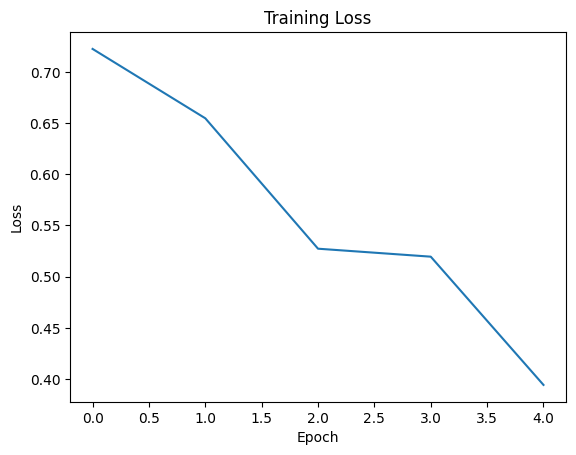

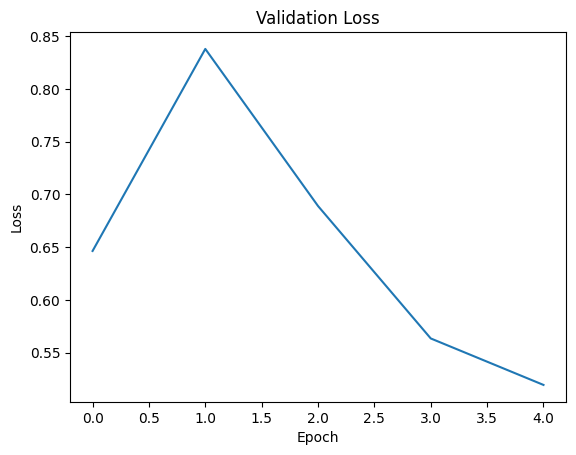

In [96]:
# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

Text(0, 0.5, 'Accuracy')

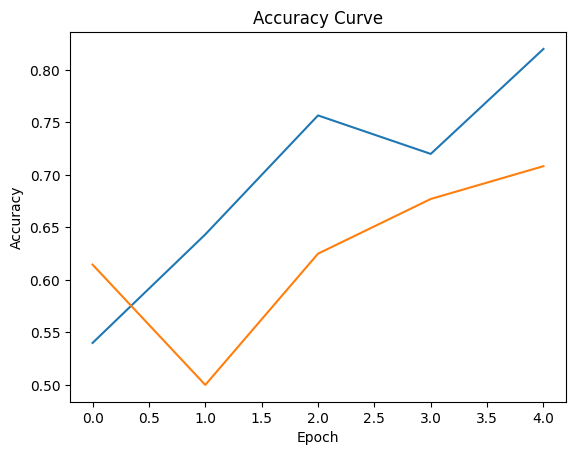

In [97]:
figsize = (5, 5)
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [98]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8438 - loss: 0.5205
Test Loss: 0.5205
Test Accuracy: 0.8438


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()



In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot image and prediction
def plot_image_with_title(img_array, model, true_label, class_names):
    # Ensure image is batched (add dimension if needed)
    if img_array.ndim == 3:
        img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_label = int(prediction[0] > 0.5)  # Binary classification

    # Unnormalize if needed (model might have used Rescaling(1./255))
    img_to_show = img_array[0]
    if img_to_show.max() <= 1.0:
        img_to_show = (img_to_show * 255).astype("uint8")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img_to_show)
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}")
    plt.axis('off')
    plt.show()


In [102]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


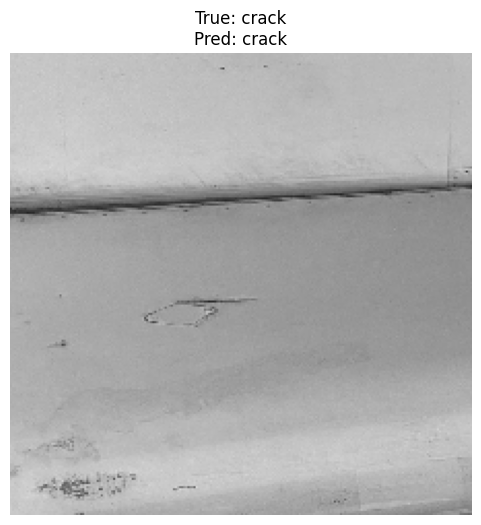

In [103]:
test_model_on_image(test_generator, model, index_to_plot=1)


## Image Captioning and Summarization using BLIP Pretrained Model


**BLIP** (Bootstrapping Language-Image Pretraining) is an advanced vision-and-language model designed to generate natural language descriptions for images. By leveraging both visual and textual information, BLIP can produce human-readable text that accurately reflects the content and context of an image. It is specifically trained to understand images and their relationships to summarizing text, making it ideal for tasks like image captioning, summarization, and visual question answering.

In this project, learners will utilize the BLIP model to build a system capable of automatically generating captions and summary for images. The code will integrate the BLIP model within a custom Keras layer. This allows the user to input an image and specify a task, either "caption" or "summary", to receive a textual output that describes or summarizes the content of the image.

#### Key Steps:
**Image Loading and Preprocessing**: The code will begin by loading images from a file path, then converting and processing them into a format suitable for input to the BLIP model.

**Text Generation**: Depending on the task, whether generating a caption or summary, the BLIP model will generate corresponding text based on the processed image.

**Custom Keras Layer**: A custom Keras layer is a user-defined layer that extends Keras' built-in functionality.Here custom Keras layer will be implemented to wrap the BLIP model. This layer will handle the task-specific processing (captioning or summarizing) and integrate smoothly into a TensorFlow/Keras environment.

In [2]:
#Load the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration


**Load the BLIP Model and Processor from Hugging Face**
Hugging Face is an open-source platform that provides pre-trained machine learning models, datasets, and tools, primarily focused on natural language processing, computer vision, and other AI tasks. It offers easy access to powerful models through its Transformers library.

**BlipProcessor**: This handles the preprocessing of images and text. It converts images to the format that the BLIP model can understand.

**BlipForConditionalGeneration**: This is the model itself, responsible for generating captions or summaries based on the processed image.

In [3]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

c:\Users\RISHABH\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"


In [5]:
def generate_text(image_path, task, processor, model):
    """
    Generates a caption or summary for a given image using the BLIP model.

    Args:
        image_path (tf.Tensor): Path to the image file as a TensorFlow string tensor.
        task (tf.Tensor): Task type as a TensorFlow string tensor, either "caption" or "summary".
        processor: The BLIP processor for image/text preprocessing.
        model: The BLIP model used to generate text.

    Returns:
        tf.Tensor: The generated text (caption or summary) as a TensorFlow string tensor.
    """
    # Create an instance of the custom Keras layer
    blip_layer = BlipCaptionSummaryLayer(processor, model)

    # Call the layer with the image path and task
    output_text = blip_layer(image_path, task)

    return output_text


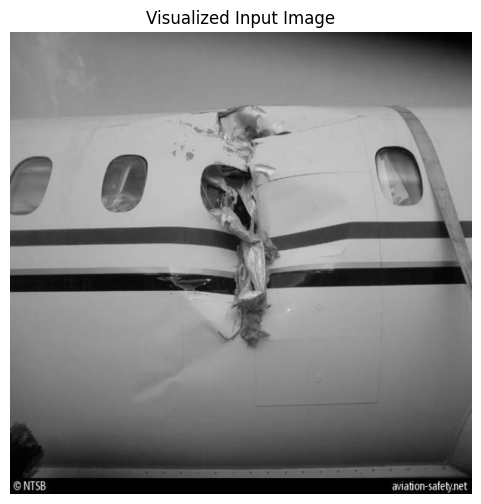

In [12]:
import matplotlib.pyplot as plt
from PIL import Image



# Define the image path (update the path as needed)
image_path = tf.constant(r"aircraft_damage_dataset_v1/test/crack/143_0_JPG_jpg.rf.6a95ea163581ec7c566872f750ee120e.jpg")

# Load and show the image
img_path = image_path.numpy().decode("utf-8")  # Convert tf.Tensor to string
img = Image.open(img_path).convert("RGB")

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Visualized Input Image")
plt.show(block=True)  # Required in VS Code to keep the window open

In [13]:
# Path to an example image 
image_path = tf.constant(r"aircraft_damage_dataset_v1/test/crack/143_0_JPG_jpg.rf.6a95ea163581ec7c566872f750ee120e.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"), processor, model)
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"), processor, model)
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Caption: this is a picture of a plane that was damaged
Summary: this is a detailed photo showing the damage of the aircraft


Caption: this is a picture of a plane that was sitting on the ground in a field
Summary: this is a detailed photo showing the damage to the fuselage of the aircraft


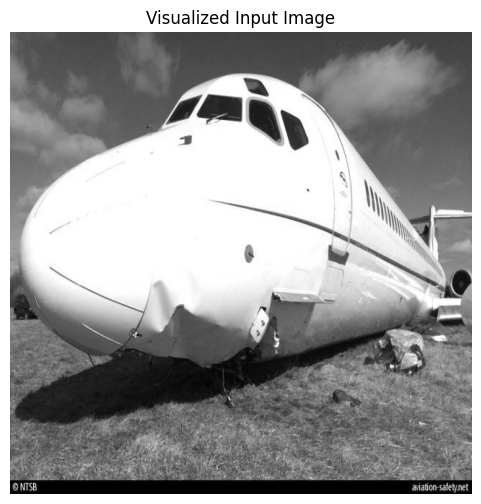

In [ ]:
# Provided image path as a tf.constant
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")
caption = generate_text(image_path, tf.constant("caption"), processor, model)
print("Caption:", caption.numpy().decode("utf-8"))



# ✅ Generate a summary
summary = generate_text(image_path, tf.constant("summary"), processor, model)

# ✅ Decode and print the summary
print("Summary:", summary.numpy().decode("utf-8"))

# ✅ Visualize the image (optional but useful)
img = Image.open(image_path.numpy().decode("utf-8")).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Visualized Input Image")
plt.show(block=True)  # Required for VS Code


Caption: this is a picture of a jet engine
Summary: this is a detailed photo showing the turbine of a boeing 747


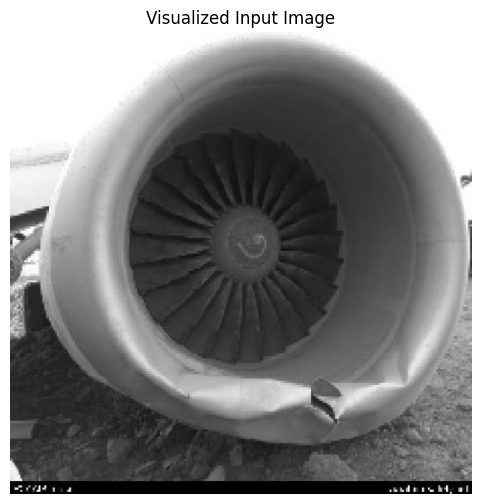

In [16]:
image_path = tf.constant(r"aircraft_damage_dataset_v1/test/dent/146_21_JPG_jpg.rf.62814adf2e016eb273290756cff2e993.jpg")  # actual path of image
# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"), processor, model)
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"), processor, model)
print("Summary:", summary.numpy().decode("utf-8"))

# Visualize the image
img = Image.open(image_path.numpy().decode("utf-8")).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Visualized Input Image")
plt.show(block=True)  # Required for VS Code

Caption: this is a picture of a plane that was damaged
Summary: this is a detailed photo showing the damage on the fuselage of a b 52 stratner


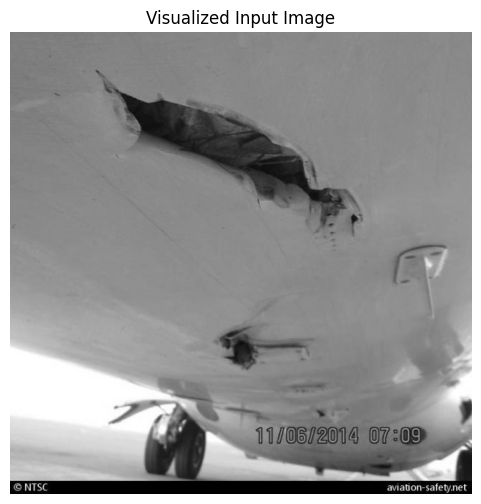

In [20]:

image_path = tf.constant(r"aircraft_damage_dataset_v1/test/crack/147_2_JPG_jpg.rf.802b0015783a68295804fba0280b0917.jpg")  # actual path of image
# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"), processor, model)
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"), processor, model)
print("Summary:", summary.numpy().decode("utf-8"))

# Visualize the image
img = Image.open(image_path.numpy().decode("utf-8")).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Visualized Input Image")
plt.show(block=True)  

Caption: this is a picture of a plane that has been damaged
Summary: this is a detailed photo showing the damage on the wing of the aircraft


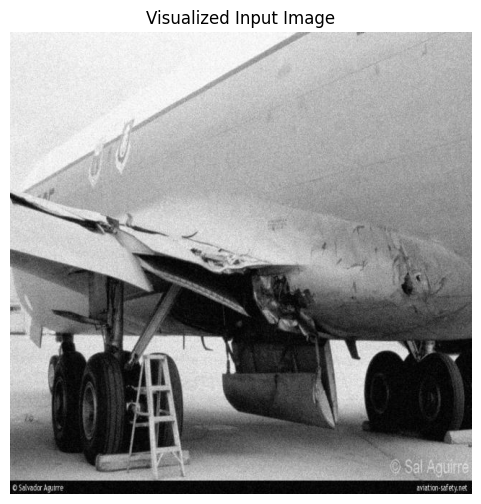

In [21]:
image_path = tf.constant(r"aircraft_damage_dataset_v1/test/dent/161_6_JPG_jpg.rf.4ade35715c20be78546832880ae2bed7.jpg")  # actual path of image
# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"), processor, model)
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"), processor, model)
print("Summary:", summary.numpy().decode("utf-8"))

# Visualize the image
img = Image.open(image_path.numpy().decode("utf-8")).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Visualized Input Image")
plt.show(block=True)  # Required for VS Code

In [24]:
import pandas as pd
from IPython.display import HTML, display

# ------------------------------------------------------------------
# 1️⃣  Fill in the five rows exactly as you listed them (1 to 5)
# ------------------------------------------------------------------
rows = [
    {
        "No": 1,
        "Image": r"aircraft_damage_dataset_v1/test/crack/143_0_JPG_jpg.rf.6a95ea163581ec7c566872f750ee120e.jpg",
        "Caption": "this is a picture of a plane that was damaged",
        "Summary": "this is a detailed photo showing the damage of the aircraft"
    },
    {
        "No": 2,
        "Image": r"aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg",
        "Caption": "this is a picture of a plane that was sitting on the ground in a field",
        "Summary": "this is a detailed photo showing the damage to the fuselage of the aircraft"
    },
    {
        "No": 3,
        "Image": r"aircraft_damage_dataset_v1/test/dent/146_21_JPG_jpg.rf.62814adf2e016eb273290756cff2e993.jpg",
        "Caption": "this is a picture of a jet engine",
        "Summary": "this is a detailed photo showing the turbine of a boeing 747"
    },
    {
        "No": 4,
        "Image": r"aircraft_damage_dataset_v1/test/crack/147_2_JPG_jpg.rf.802b0015783a68295804fba0280b0917.jpg",
        "Caption": "this is a picture of a plane that was damaged",
        "Summary": "this is a detailed photo showing the damage on the fuselage of a b 52 stratner"
    },
    {
        "No": 5,
        "Image": r"aircraft_damage_dataset_v1/test/dent/161_6_JPG_jpg.rf.4ade35715c20be78546832880ae2bed7.jpg",
        "Caption": "this is a picture of a plane that has been damaged",
        "Summary": "this is a detailed photo showing the damage on the wing of the aircraft"
    },
]

# ------------------------------------------------------------------
# 2️⃣  Create DataFrame
# ------------------------------------------------------------------
df = pd.DataFrame(rows)

# ------------------------------------------------------------------
# 3️⃣  Display table with inline images (inside Jupyter / Colab)
# ------------------------------------------------------------------
def show_image_table(df):
    html = (
        "<table>"
        "<tr><th>No</th><th>Image</th><th>Caption</th><th>Summary</th></tr>"
    )
    for _, row in df.iterrows():
        img_tag = f"<img src='{row['Image']}' width='250'/>"
        html += (
            f"<tr>"
            f"<td style='text-align:center;'>{row['No']}</td>"
            f"<td>{img_tag}</td>"
            f"<td>{row['Caption']}</td>"
            f"<td>{row['Summary']}</td>"
            f"</tr>"
        )
    html += "</table>"
    display(HTML(html))

show_image_table(df)


No,Image,Caption,Summary
1,,this is a picture of a plane that was damaged,this is a detailed photo showing the damage of the aircraft
2,,this is a picture of a plane that was sitting on the ground in a field,this is a detailed photo showing the damage to the fuselage of the aircraft
3,,this is a picture of a jet engine,this is a detailed photo showing the turbine of a boeing 747
4,,this is a picture of a plane that was damaged,this is a detailed photo showing the damage on the fuselage of a b 52 stratner
5,,this is a picture of a plane that has been damaged,this is a detailed photo showing the damage on the wing of the aircraft


In [26]:
df["Image"] = [
    "aircraft_damage_dataset_v1/test/crack/143_0_JPG_jpg.rf.6a95ea163581ec7c566872f750ee120e.jpg",
    "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg",
    "aircraft_damage_dataset_v1/test/dent/146_21_JPG_jpg.rf.62814adf2e016eb273290756cff2e993.jpg",
    "aircraft_damage_dataset_v1/test/crack/147_2_JPG_jpg.rf.802b0015783a68295804fba0280b0917.jpg",
    "aircraft_damage_dataset_v1/test/dent/161_6_JPG_jpg.rf.4ade35715c20be78546832880ae2bed7.jpg"
]

# Move image column first
df = df[["No", "Image", "Caption", "Summary"]]

# Format image cells as HTML
df["Image"] = df["Image"].apply(lambda path: f"<img src='{path}' width='250'>")

# Save as interactive HTML file with images
with open("caption_summary_with_images.html", "w") as f:
    f.write(df.to_html(escape=False, index=False))

print("✅ Saved as caption_summary_with_images.html")


✅ Saved as caption_summary_with_images.html


## ✅ Final Summary & Learnings

This project combined computer vision and NLP to automate aircraft damage inspection:

- ✅ Achieved 84.38% test accuracy using VGG16 for classifying crack vs. dent.
- ✅ Successfully integrated BLIP transformer to generate descriptive captions and summaries of damage.
- ✅ Evaluated captioning results qualitatively using a custom 5-image output table.
- ✅ Learned to apply dual-task deep learning pipelines using CNN + Transformer.
- ✅ Discovered challenges of caption evaluation when reference texts are not available.

## 🚀 Future Work

- 🔄 Fine-tune BLIP or train on a domain-specific damage caption dataset.
- 📊 Add automatic evaluation using BLEU/METEOR if references are available.
- 🌐 Deploy as a web app using Streamlit or Gradio for real-time aircraft image analysis.
